In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidi

In [14]:
!pip install pycocotools
!pip install transformers timm --quiet
!pip install wandb



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install -q gdown
!gdown --id 1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ --output "./AU-AIR.zip"


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ
From (redirected): https://drive.google.com/uc?id=1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ&confirm=t&uuid=b237bab4-daae-40f3-94e0-4d856820eb54
To: c:\Users\Ali\Desktop\DI725_asg2_repo\DI725_Assignment2\AU-AIR.zip

  0%|          | 0.00/2.32G [00:00<?, ?B/s]
  0%|          | 524k/2.32G [00:03<4:31:04, 142kB/s]
  0%|          | 1.05M/2.32G [00:05<2:55:57, 219kB/s]
  0%|          | 1.57M/2.32G [00:05<1:53:17, 341kB/s]
  0%|          | 2.10M/2.32G [00:06<1:17:42, 497kB/s]
  0%|          | 2.62M/2.32G [00:06<55:14, 699kB/s]  
  0%

In [2]:
import zipfile

with zipfile.ZipFile("./AU-AIR.zip", 'r') as zip_ref:
    zip_ref.extractall("./AU-AIR")


In [3]:
!mkdir -p annotations

In [8]:
import json

with open('./annotations/annotations.json') as f:
    data = json.load(f)

# Preprocessing

### Clean the keys of annotations from ':'.

In [9]:
import json

# File paths
input_path = "./annotations/annotations.json"
output_path = "./annotations/annotations.json"

# Recursive function to clean dictionary keys
def clean_keys(obj):
    if isinstance(obj, dict):
        return {k.rstrip(":"): clean_keys(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_keys(i) for i in obj]
    else:
        return obj

# Load original data
with open(input_path, "r") as f:
    raw_data = json.load(f)

# Clean all keys
cleaned_data = clean_keys(raw_data)

# Save cleaned data
with open(output_path, "w") as f:
    json.dump(cleaned_data, f, indent=4)

print(f"✅ Cleaned annotations saved to: {output_path}")


✅ Cleaned annotations saved to: ./annotations/annotations.json


### Convert the annotations to COCO format

In [10]:
import json
import os

# Step 1: Load cleaned annotation file
with open("./annotations/annotations.json", "r") as f:
    auair_data = json.load(f)

# Step 2: Convert to COCO format
def convert_auair_to_coco(auair_data, output_path="auair_coco.json"):
    images = []
    annotations = []

    # Define COCO-style categories from class names
    categories = [{"id": i, "name": name} for i, name in enumerate(auair_data["categories"])]

    ann_id = 1  # unique annotation ID
    for img_id, entry in enumerate(auair_data["annotations"]):
        image_name = entry["image_name"]
        width = entry["image_width"]
        height = entry["image_height"]

        images.append({
            "id": img_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        for bbox in entry["bbox"]:
            x = bbox["left"]
            y = bbox["top"]
            w = bbox["width"]
            h = bbox["height"]
            category_id = bbox["class"]

            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],       # COCO: [x, y, width, height]
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    # Step 3: Save to COCO format JSON file
    with open(output_path, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"✅ COCO-format annotations saved to: {output_path}")

# Step 4: Run the conversion
convert_auair_to_coco(
    auair_data,
    output_path="./annotations/auair_coco.json"
)


✅ COCO-format annotations saved to: ./annotations/auair_coco.json


### Filter the COCO annotations such that images that are not annotated and/or annotated but no image file exists

In [11]:
import os
import json

# === PATHS ===
image_folder = "./AU-AIR/images"
annotation_file = "./annotations/auair_coco.json"
filtered_annotation_path = "./annotations/auair_coco_filtered.json"

# === LOAD ANNOTATION ===
with open(annotation_file, "r") as f:
    coco = json.load(f)

# === IMAGE NAME CHECKS ===
annotated_image_names = set(img["file_name"] for img in coco["images"])
image_files = set(os.listdir(image_folder))

missing_images = annotated_image_names - image_files
unannotated_images = image_files - annotated_image_names

# === REPORT ===
print(f"✅ Total annotated images: {len(annotated_image_names)}")
print(f"📂 Total actual image files: {len(image_files)}\n")

print(f"❌ Missing image files (in annotations but not found on disk): {len(missing_images)}")
if missing_images:
    print("Examples:", sorted(list(missing_images))[:5])

print(f"📝 Unannotated image files (exist in folder but not in annotations): {len(unannotated_images)}")
if unannotated_images:
    print("Examples:", sorted(list(unannotated_images))[:5])

# === FILTER ANNOTATIONS ===
valid_images = [img for img in coco["images"] if img["file_name"] in image_files]
valid_image_ids = set(img["id"] for img in valid_images)
valid_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in valid_image_ids]

filtered_coco = {
    "images": valid_images,
    "annotations": valid_annotations,
    "categories": coco["categories"]
}

# === SAVE CLEANED JSON ===
with open(filtered_annotation_path, "w") as f:
    json.dump(filtered_coco, f, indent=4)

print(f"\n✅ Filtered COCO annotations saved to: {filtered_annotation_path}")
print(f"➡️ Valid images remaining: {len(valid_images)}")
print(f"➡️ Valid annotations remaining: {len(valid_annotations)}")


✅ Total annotated images: 32823
📂 Total actual image files: 32823

❌ Missing image files (in annotations but not found on disk): 0
📝 Unannotated image files (exist in folder but not in annotations): 0

✅ Filtered COCO annotations saved to: ./annotations/auair_coco_filtered.json
➡️ Valid images remaining: 32823
➡️ Valid annotations remaining: 132031


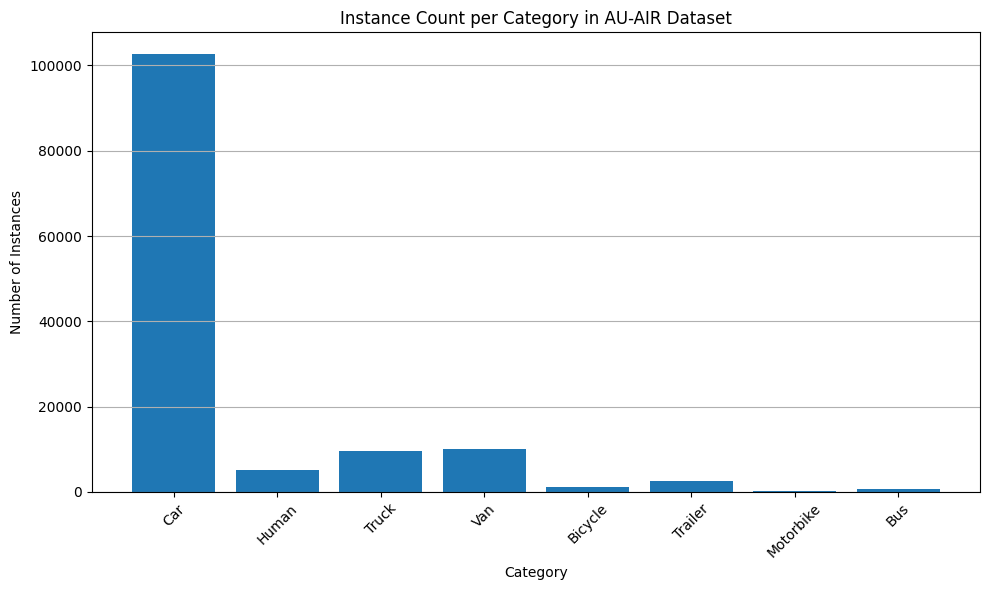

In [17]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Load COCO data
json_path = "./annotations/auair_coco_filtered.json"
with open(json_path, "r") as f:
    coco_data = json.load(f)

# Count annotations per category
category_counts = defaultdict(int)
for ann in coco_data["annotations"]:
    category_counts[ann["category_id"]] += 1

# Get category names
category_id_to_name = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Prepare data for plotting
category_names = [category_id_to_name[cat_id] for cat_id in category_counts]
counts = [category_counts[cat_id] for cat_id in category_counts]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(category_names, counts)
plt.xlabel("Category")
plt.ylabel("Number of Instances")
plt.title("Instance Count per Category in AU-AIR Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()
